# Qiskit tests
## Creation of a circuit that implements HHL for Toeplitz symmetrical tridiagonal matrix 

This notebook is based in 2 papers:

- [1] : Harrow, A. W., Hassidim, A., Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Phys. Rev. Lett. 103, 15 (2009), 1–15. <https://doi.org/10.1103/PhysRevLett.103.150502>
- [2] : Carrera Vazquez, A., Hiptmair, R., & Woerner, S. (2020). Enhancing the Quantum Linear Systems Algorithm using Richardson Extrapolation.arXiv:2009.04484 <http://arxiv.org/abs/2009.04484>`

The code is mostly based in the original code for the HHL solver in Qiskit-Algorithms

In [5]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product

1. Build circuit
2. Build observables [2]

In [6]:
def get_delta(n_l: int, lambda_min: float, lambda_max: float) -> float:
    """Calculates the scaling factor to represent exactly lambda_min on nl binary digits.

    Args:
        n_l: The number of qubits to represent the eigenvalues.
        lambda_min: the smallest eigenvalue.
        lambda_max: the largest eigenvalue.

    Returns:
        The value of the scaling factor.
    """
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2 ** n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep


In [7]:
def calculate_norm(qc: QuantumCircuit, scaling) -> float:
    """Calculates the value of the euclidean norm of the solution.

    Args:
        qc: The quantum circuit preparing the solution x to the system.

    Returns:
        The value of the euclidean norm of the solution.
    """
    # Calculate the number of qubits
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas

    # Create the Operators Zero and One
    # Pauli Strings

    # I = Identity
    # Z = Z-Gate
    uno = np.zeros(2)
    uno[-1] = 1
    aux = np.outer(uno,uno)
    I_nb = np.eye(2**nb)
    M = np.kron(aux,I_nb)
    
    # Get the state of the circuit
    statevector = Statevector(qc)
    st=np.array(statevector).real
    num = int(len(st)/2)
    
    # Define solution
    sol = []
    for i in range(2):
        sol.append(st[num+i].real)
    sol = np.array(sol)
    st = st[nb:]
    
    # Calculate observable
    M_dg = M.conj().T
    obs = M_dg @ M
    norm_2 = np.vdot(st,obs @ st)

    return np.real(np.sqrt(norm_2) / scaling)

In [8]:
#Function to build the HHL circuit
def build_circuit(matrix, vector, tolerance: float = 10e-2, flag: bool = True, meas: bool = False):
    """
    Builds the HHL circuit using the required args
    
    Args:
        `matrix`: The matrix that defines the linear system, i.e. A in Ax = b.
        `vector`: The right-hand side of the equation, i.e. b in Ax = b.
        `tolerance`: Tolerance of the solution bounds. This value is used to define the 3 tolerances needed for the HHL [2] equation (62).
        `flag`: Flag deciding whether the reciprocal circuit is or not exact
        `meas`: Flag deciding whether measures are made in the non x qubits
        
    Returns:
        The HHL circuit
    
    Raises:
        ValueError: If the data is not in the right format
        ValueError: The matrix dimension is not correct
    """
    
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray)):
        if isinstance(vector,list):
            vector = np.array(vector)    
        # We define the number of needed qubits and insert the vector to the register
        nb = int(np.log2(len(vector)))
        vector_circuit = QuantumCircuit(nb)
        vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
        # for i in range(nb):
        #     vector_circuit.h(i)
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    
    # Define flag, if 1, correct solution, if 0, incorrect
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
            raise ValueError(
                "Input vector dimension does not match input "
                "matrix dimension! Vector dimension: "
                + str(vector_circuit.num_qubits)
                + ". Matrix dimension: "
                + str(matrix.shape[0])
            )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)
        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    if flag:
        reciprocal_circuit = ExactReciprocal(nl, delta)
        # Update number of ancilla qubits
        na = matrix_circuit.num_ancillas
    
    # Using Chebyshev interpolation to approximate arcsin(C/x) to a degree of degree
    else: 
        # Calculate breakpoints for the reciprocal approximation
        num_values = 2 ** nl
        constant = delta
        # a as [2] indicates
        
        # No tengo para nada claro esto, no encuentro que hay que hacer con la a para pasarla a entero
        a = int(2**(2*nl/3))  # pylint: disable=invalid-name

        # Calculate the degree of the polynomial and the number of intervals
        r = 2 * constant / a + np.sqrt(np.abs(1 - (2 * constant / a) ** 2))
        degree = min(nb,int(np.log(1+(16.23* np.sqrt(np.log(r) ** 2 + (np.pi / 2) ** 2)* kappa* (2 * kappa - epsilon_r))/ epsilon_r)),)
        # As [2]
        num_intervals = int(np.ceil(np.log((num_values - 1) / a) / np.log(5)))

        # Calculate breakpoints and polynomials
        breakpoints = []
        for i in range(0, num_intervals):
            # Add the breakpoint to the list
            breakpoints.append(a * (5 ** i))

            # Define the right breakpoint of the interval
            if i == num_intervals - 1:
                breakpoints.append(num_values - 1)
        # Once we have the intervals, and everything is defined, we can make an approximation by a polynomial function of degree
        reciprocal_circuit = PiecewiseChebyshev(
            lambda x: np.arcsin(constant / x), degree, breakpoints, nl, name="c_Rot"
        )
        # Number of ancilla qubits
        na = max(matrix_circuit.num_ancillas, reciprocal_circuit.num_ancillas)
        
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    if na > 0:
        qa = AncillaRegister(na,name="anc")  # ancilla qubits
    qf = QuantumRegister(nf,name="flag")  # flag qubits

    if na > 0:
        qc = QuantumCircuit(qb, ql, qa, qf)
    else:
        qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.append(vector_circuit, qb[:])
    qc.barrier(label="\pi_1")
    # QPE
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    if na > 0:
        qc.append(phase_estimation, ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation, ql[:] + qb[:])
    qc.barrier(label="\pi_2")
    # Conditioned rotation
    if flag:
        qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
    else:
        qc.append(
            reciprocal_circuit.to_instruction(),
            ql[::-1] + [qf[0]] + qa[: reciprocal_circuit.num_ancillas],
        )
    
    qc.barrier(label="\pi_3")
    # QPE inverse
    if na > 0:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:])
    
    if meas:
        qc.measure_all()
    return qc,scaling

In [9]:
# Calc observables
def calc_observables(qc: QuantumCircuit, observable: Optional[int] = 3):
    """Calculates the value of the observable(s) given.

        Args:
            `qc`: The quantum circuit preparing the solution x to the system.
            # TODO
            # Not yet implemented
            `observable`: Information to be extracted from the solution. 1 - ||x'||, 2 - F_b(x), 3 - Average solution
            `post_processing`: Function to compute the value of the observable.

        Returns:
            The value of the observable(s) and the circuit results before post-processing as a tuple.
        """
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas
    
    
    solution = 0
    return solution

In [10]:
# Solve circuit
def solve(qc: QuantumCircuit):
    solution = 0
    return solution

In [11]:
def tridiag_matrix(diag,up,n) -> np.ndarray:
    """Returns a tridiagonal symmetrical matrix
    
    Args:
        `diag`: Value of the diagonal
        `up`: Value of the subdiagonals
        `n`: Size of the matrix
    
    Returns:
        The matrix
    """
    if n<2: 
        raise ValueError("The dimension of the matrix must be greater than 2")
    
    rows = []
    
    for i in range(n):
        row = np.zeros(n)
        if i>0:
            row[i-1]=up
        row[i]=diag
        if i<n-1:
            row[i+1]=up
            
        rows.append(row)
        
    matrix = np.array(rows)
    return matrix

In [12]:
def create_observable(qc: QuantumCircuit):
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas
    
    zero_op = np.array([[1,0],[0,0]])
    one_op = np.array([[0,0],[0,1]])
    t_zero= zero_op
    t_one = one_op
    
    for _ in range(nl+na):
        t_zero = np.kron(t_zero,zero_op)
        
    for _ in range(nb):
        t_one = np.kron(t_one,one_op)
        
    observable = np.kron(t_one,np.kron(t_zero,t_one))
    return observable

In [13]:
def calculate_expectation_value_from_counts(counts, observable):
    expectation_value = 0
    total_shots = sum(counts.values())
    
    for outcome, count in counts.items():
        prob = count / total_shots
        # Convert binary string outcome to integer
        outcome_index = int(outcome, 2)
        # Extract the diagonal element corresponding to the outcome
        expectation_value += prob * observable[outcome_index, outcome_index]
    
    return expectation_value

In [89]:
def solution(qc: QuantumCircuit) -> np.ndarray:
    statevector = Statevector(qc)
    st=np.array(statevector)
    num = int(len(st)/2)
    sol = []
    for i in range(2**qc.qregs[0].size):
        sol.append(st[num+i].real)
    sol = np.array(sol)
    sol = sol/np.linalg.norm(sol)
    return sol

---
# **Test**

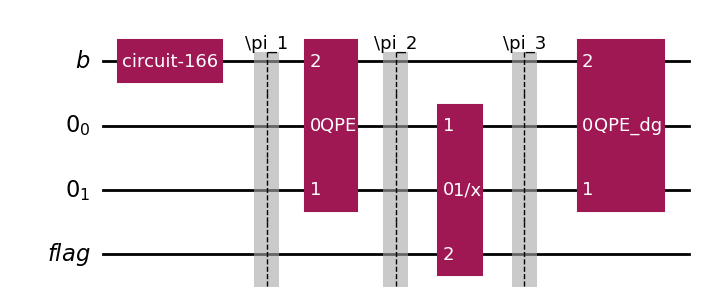

In [15]:
vector = np.array([1,1])
matrix = tridiag_matrix(2,-1,2)

hhl,scaling = build_circuit(matrix,vector,10e-2,flag=True)
hhl.draw('mpl')


# Code to print the circuit into latex code
# tes=hhl.draw('latex_source')
# f = open('aux.tex','a+')
# f.write(tes)
# f.close()

# hhl_d = hhl.decompose(reps=5)

# hhl_d.draw('mpl')


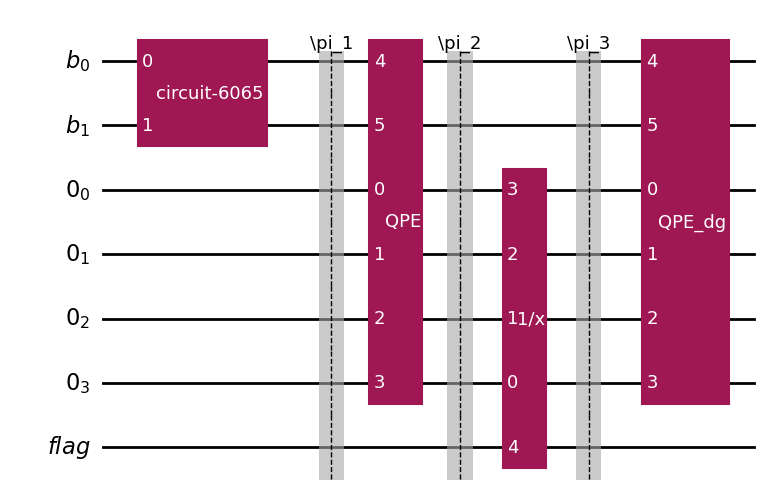

In [85]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
hhl,_ = build_circuit(matrix,vector,flag=True)
hhl.decompose(reps=0).draw('mpl')

-----
We can test the circuit using statevectors

In [90]:
sol1=solution(hhl)
print(sol1)

[0.39206738 0.5884583  0.5884583  0.39206738]


Exact solution

In [18]:
sol=np.linalg.solve(matrix,vector/np.linalg.norm(vector))
sol/np.linalg.norm(sol)
norm=np.sqrt(sum(sol**2))

sol2=sol/norm
print(sol2)

[0.39223227 0.58834841 0.58834841 0.39223227]


If we have a 2-dimensional vector, the solution with statevectors is exact (we only have one qubit for $b$). But as we increase the dimension, the solution worsens

In [19]:
diff = np.abs(sol1-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.00016489 0.00010989 0.00010989 0.00016489]
The norm of the diff is: 0.000280227056225066


-----
## Simulation with shots

In [20]:
def prob_from_counts(counts,shots: int, repeat) -> np.ndarray:
    """ Calculates the expected amplitudes of the solution |x> without normalization
    
    Args:
        `counts`: Counts as a dictionary {'xxxxx': number}, obtained from a simulation or run in a real QPU
        `shots`: Number of shots (runs) of the circuit
        `repeat`: Number of qubits used to represent the right-hand side vector in the system
    Returns:
        The non normalized amplitudes of the solution. To get the real solution, you should normalize it and multiply it by the norm of the solution.
    """ 
    if not isinstance(repeat,int):
        repeat = int(repeat)
        
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=repeat)]

    # Initialize the dictionary with each binary string as a key and a value of 0
    prob_amplitudes = {outcome: 0 for outcome in all_outcomes}

    for outcome, count in counts.items():
        first_qubit_state = outcome[-repeat:]  # Get the state of the first qubit
        prob_amplitudes[first_qubit_state] += count / shots

    ampl = np.array(list(prob_amplitudes.values()))
    return ampl

Estimated amplitudes of the solution: [0.16516113 0.3371582  0.33032227 0.1673584 ]


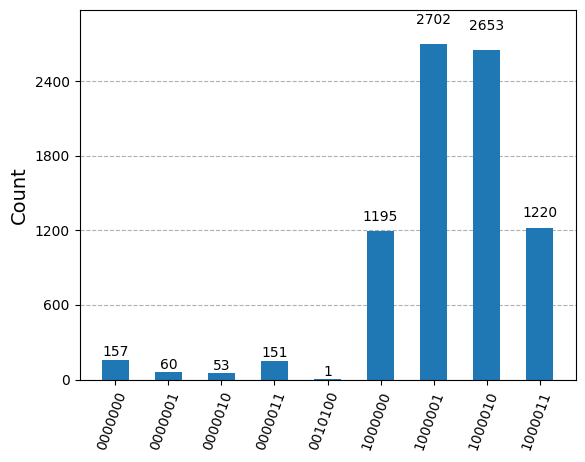

In [21]:
sim = AerSimulator()
hhl_meas,_ = build_circuit(matrix,vector,10e-4,True,True)
hhl_meas = transpile(hhl_meas,sim)

sampler = SamplerV2()

shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()

counts=job_result[0].data.meas.get_counts()

prob_amplitudes = prob_from_counts(counts,shots,np.log2(len(vector)))

print("Estimated amplitudes of the solution:", prob_amplitudes)

plot_histogram(job_result[0].data.meas.get_counts())

Una vez tenemos las amplitudes calculadas, podemos ver su distancia con el valor real del problema. Para poder compararlas, debemos hacer $\frac{\vec{x}}{||\vec{x}||}$, sobre el diccionario de valores

In [22]:
ampl = prob_amplitudes/np.linalg.norm(prob_amplitudes)

# Calculate the difference
diff = np.abs(ampl-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.07902885 0.05102178 0.03805844 0.07486206]
The norm of the diff is: 0.12610136144071446


Pruebas distintas de observables

In [23]:
from qiskit_aer.primitives import SamplerV2

sim = AerSimulator()
hhl_meas = hhl
hhl_meas.measure_all()

hhl_meas = transpile(hhl,sim)

sampler = SamplerV2()
shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
filtered_counts = {k: v for k, v in counts.items() if k[0] == '1'}
total_filtered_counts = sum(filtered_counts.values())
norm_b = np.linalg.norm(vector)

P1 = total_filtered_counts/shots
eigs = np.linalg.eigvals(matrix)
nl = hhl.qregs[1].size
C = get_delta(nl,min(eigs),max(eigs))*2**nl
c = 1

norm_x = (P1/(C**2))**0.5

print(f'||x|| = {norm_x}')


||x|| = 0.9737772781801801


---
## Error de la solución

Se tendrá que, siendo $\vec{x}$ la solución del problema con el vector de lados derechos normalizada, $\vec{x}'$ el vector resultante del problema, se tredrá que $\vec{x}=\frac{||\vec{x}||\cdot\vec{x}'}{||\vec{x}'||}$. Por lo tanto, utilizando el observable indicado en [2] además de los valores obtenidos, podremos obtener este valor.

In [24]:
sol_e = np.linalg.solve(matrix,vector)
np.linalg.norm(sol_e)**2

25.999999999999996

El error daba errores, así que voy a pasar de ello un poco de momento

---
## Aproximación del vector de lados derechos por una serie de potencias

In [25]:
size = 2
qr = QuantumRegister(size,name='q')
qa = AncillaRegister(1,name="a")
qc = QuantumCircuit(qr,qa)

for i in range(size):
    qc.h(i)
# p(x) = x^2 + x + 1

qc.ry(2*1,qa)
qc.cry(2*(4+2),qr[1],qa)
qc.cry(2*(1+1),qr[0],qa)
qc.mcry(2*4,qr[:],qa)

#qc.initialize(vector/np.linalg.norm(vector),range(2),None)

print(qc.draw())

st = Statevector(qc)

st.data.real[4:]

       ┌───┐                                                  
q_0: ──┤ H ├────────────────■───────────────■──────────────■──
       ├───┤                │               │              │  
q_1: ──┤ H ├──────■─────────┼───────────────■──────────────■──
     ┌─┴───┴─┐┌───┴────┐┌───┴───┐┌───────┐┌─┴─┐┌────────┐┌─┴─┐
  a: ┤ Ry(2) ├┤ Ry(12) ├┤ Ry(4) ├┤ Ry(4) ├┤ X ├┤ Ry(-4) ├┤ X ├
     └───────┘└────────┘└───────┘└───────┘└───┘└────────┘└───┘


array([0.42073549, 0.07056   , 0.3284933 , 0.21008352])

In [26]:
def parse_func(poly_str):
    # Remove spaces
    poly_str = poly_str.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    poly_str = poly_str.replace('-', '+-')
    if poly_str[0] == '+':
        poly_str = poly_str[1:]
    
    # Split the string into terms
    terms = poly_str.split('+')
    
    coefficients = {}
    max_degree = 0
    
    for term in terms:
        if 'x' in term:
            if '^' in term:
                coef, exp = term.split('x^')
                exp = int(exp)
            else:
                coef, exp = term.split('x')
                exp = 1
            
            if coef in ('', '+'):
                coef = 1
            elif coef == '-':
                coef = -1
            else:
                coef = int(coef)
        else:
            coef = int(term)
            exp = 0
        
        coefficients[exp] = coef
        if exp > max_degree:
            max_degree = exp
    
    # Fill missing degrees with 0
    all_coefficients = [coefficients.get(i, 0) for i in range(max_degree + 1)]
    return all_coefficients

def value_func(coefs,nb):
    
    if not isinstance(coefs,np.ndarray):
        coefs = np.array(coefs)
    
    size = 2**nb
    
    pol=[]
    for i in range(size):
        aux = 0
        for j in range(1,len(coefs)):
            aux +=coefs[j]*i**j
        pol.append(aux)     
    
    return pol

def b_state(nb: int,function: str,c: float = 1) -> QuantumCircuit:
    """Defines the b state from an approximation polynomic function
    
    Args:
        `nb`: The number of qubits needed to represent the vector
        `function`: A string representing the function. The style must be: 'ax^n+bx^n-1+...+z'. Where a,b,...,z are the amplitudes.
        
    """
    qr = QuantumRegister(nb,name="b")
    qa = AncillaRegister(1,name='a')
    qc = QuantumCircuit(qr,qa)
    
    qc.h(qr[:])
    
    # Processing of `function`
    ampl = parse_func(function)
    
    # Value of `function`
    pol = value_func(ampl,nb)
    
    if ampl[0]!=0:
        qc.ry(2*ampl[0]*c,qa)
    
    size = 2**nb
    
    for i in range(1,size):        
        if (np.floor(np.log2(i))==np.ceil(np.log2(i))):
            if pol[i]!=0:
                qc.cry(2*pol[i]*c,qr[int(np.log2(i))],qa)
        else:
            bin_aux = bin(i)[2:]
            index = [len(bin_aux) - 1 - j for j, digit in enumerate(bin_aux) if digit == '1' ]
            # I dont remember why this 2**i, but it made sense in the moment i coded it
            aux = [pol[2**i] for i in index]
            elem = pol[i]-np.sum(aux)
            if elem != 0:
                qc.mcry(2*elem*c,index,qa)     
    return qc

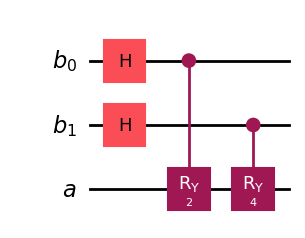

In [27]:
b = b_state(2,'x',1)
b.draw('mpl')

In [28]:
b = b_state(2,'x',1)
state = Statevector(b)
state = state.data.real[4:]
state/np.linalg.norm(state)

array([0.        , 0.67483946, 0.72923464, 0.11317485])

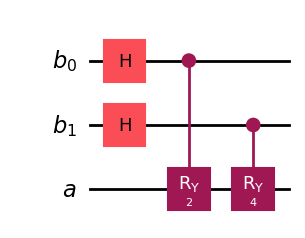

In [29]:
b.draw('mpl')

In [30]:
arr = np.array([0,1/3,2/3,1])
qc = QuantumCircuit(2)
qc.initialize(arr/np.linalg.norm(arr))
state = Statevector(qc)
print(state.data.real)

[0.         0.26726124 0.53452248 0.80178373]


---
## Number of gates study

This is an experimental analysis of the number of gates based on the size of the problem. First we test it with the exact rotation, then with the Chebyshev approximation. We get the total number of gates, but one of the advantages of QC is that you can run multiple gates simultaneously. To have that into consideration, we can introduce a rescaling factor. Most times, you can perform 2 gates at the same time, so the scaling factor would be ($\lambda=\frac{1}{1.5}\approx0.667$)

- Exact rotation

In [31]:
# gates={}
# for i in range(4):
#     size = 2**(i+1)
#     vector = np.array([1]*size)
#     matrix = tridiag_matrix(2,-1,size)
#     hhl,_ = build_circuit(matrix,vector,flag=True)
#     count = hhl.decompose(reps=6).count_ops()
#     tot_gates=-3
#     for elem in count.items():
#         tot_gates += elem[1]
#     gates[size]=tot_gates
#     print(f'Number of gates in circuit of size {size}: {tot_gates}')

In [32]:
# import matplotlib.pyplot as plt

# keys = list(gates.keys())
# values = list(gates.values())

# plt.figure(figsize=(10, 5))
# plt.plot(keys, values, marker='o', linestyle='-', color='blue')
# plt.xlabel('Size')
# plt.ylabel('Gates')
# plt.title('Line Plot of Dictionary')
# plt.grid(True)
# plt.show()

- Chebyshev piecewise function approximation

In [33]:
# gates_est={}
# for i in range(4):
#     size = 2**(i+1)
#     vector = np.array([1]*size)
#     matrix = tridiag_matrix(2,-1,size)
#     hhl,_ = build_circuit(matrix,vector,flag=False)
#     count = hhl.decompose(reps=6).count_ops()
#     tot_gates=-3
#     for elem in count.items():
#         tot_gates += elem[1]
#     gates_est[size]=tot_gates
#     print(f'Number of gates in circuit of size {size}: {tot_gates}')

In [34]:
# keys = list(gates_est.keys())
# values = list(gates_est.values())

# plt.figure(figsize=(10, 5))
# plt.plot(keys, values, marker='o', linestyle='-', color='red')
# plt.xlabel('Size')
# plt.ylabel('Gates')
# plt.title('Line Plot of Dictionary')
# plt.grid(True)
# plt.show()

In [35]:
# import matplotlib.pyplot as plt

# keys_1 = list(gates.keys())
# values_1 = list(gates.values())
# keys = list(gates_est.keys())
# values = list(gates_est.values())

# # plt.figure(figsize=(10, 7))

# plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
# plt.plot(keys, values, marker='o', linestyle='-', color='red')
# plt.yscale('log')
# plt.xlabel('Size')
# plt.ylabel('Gates')
# plt.title('Comparation in the number of needed gates')
# plt.legend(['Exact Rotation','Chebyshev approximation'])
# plt.grid(True)
# plt.show()

- Number of circuit actions

In [36]:
# scaling = 1/1.5
# # Time used in each gate (in nanoseconds)
# time_gate= 30
# aprox_time_exact = np.array(list(gates.values()))*scaling
# aprox_time_est = np.array(list(gates_est.values()))*scaling
# diff = aprox_time_est-aprox_time_exact
# diff_rel = diff/aprox_time_est
# np.set_printoptions(suppress=True)
# print(f'The number of actions of the exact circuit: {aprox_time_exact}')
# print(f'The number of actions of the approx circuit: {aprox_time_est}')
# print(f'Time exact circuit: {time_gate*aprox_time_exact/1000}')
# print(f'Time approx circuit: {time_gate*aprox_time_est/1000}')
# print(f'Difference: {diff}')
# print(f'Relative difference: {diff_rel}')
# print(f'Approximate time difference: {time_gate*diff/1000} us')

---

## Test using a hybrid approach

We first have to slice the circuit into 3 different parts:
1) The initialization and the QPE
2) The eigenvalue inversion
3) The QPE_dg

Once we have the circuit divided into this three parts we can run them separately (no simultaneously) using different approaches:
- The first and last circuits are run in a noisy simulator (probably with statevectors)
- The second circuit is run in a real QPU (using shots)

To do that, we first have to divide the circuit function into 3 parts so that:
`
qc1.append(qc2.append(qc3))
`
is the full circuit as we already have

In [37]:
# Function definition
def init_and_qpe(vector,matrix,tolerance=10e-3):
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray)):
        if isinstance(vector,list):
            vector = np.array(vector)    
        # We define the number of needed qubits and insert the vector to the register
        nb = int(np.log2(len(vector)))
        vector_circuit = QuantumCircuit(nb)
        vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
        # for i in range(nb):
        #     vector_circuit.h(i)
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    
    # Define flag, if 1, correct solution, if 0, incorrect
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
            raise ValueError(
                "Input vector dimension does not match input "
                "matrix dimension! Vector dimension: "
                + str(vector_circuit.num_qubits)
                + ". Matrix dimension: "
                + str(matrix.shape[0])
            )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    qf = QuantumRegister(nf,name="flag")  # flag qubits
    qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.append(vector_circuit, qb[:])
    qc.barrier(label="\pi_1")
    # QPE
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    qc.append(phase_estimation, ql[:] + qb[:])
    return qc,nb,nl,matrix_circuit
##########################################################################

def eig_inverse(state,nb,nl,matrix_circuit):
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)
        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    
    reciprocal_circuit = ExactReciprocal(nl, delta)
    # Update number of ancilla qubits
    na = matrix_circuit.num_ancillas
    
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    if na > 0:
        qa = AncillaRegister(na,name="anc")  # ancilla qubits
    qf = QuantumRegister(1,name="flag")  # flag qubits

    if na > 0:
        qc = QuantumCircuit(qb, ql, qa, qf)
    else:
        qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.initialize(state)
    # Conditioned rotation
    qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
    
    return qc,scaling

##########################################################################

def inverse_qpe(state,nb,nl,matrix_circuit):
       
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    qf = QuantumRegister(1,name="flag")  # flag qubits
    qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.initialize(state)
    # QPE inverse
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    qc.append(phase_estimation.inverse(), ql[:] + qb[:])

    return qc

In [105]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
qc1,nb,nl,mt_circ=init_and_qpe(vector,matrix)
state = Statevector(qc1)
qc2,_ = eig_inverse(state,nb,nl,mt_circ)
state2 = Statevector(qc2)
test = np.abs(state2)
qc3 = inverse_qpe(state2,nb,nl,mt_circ)
state_f = solution(qc3)
print(state_f)

[0.37728756 0.59804189 0.59804189 0.37728756]


In [51]:
prb = np.linalg.solve(matrix,vector)
print(prb/np.linalg.norm(prb))

[0.39223227 0.58834841 0.58834841 0.39223227]


As we can see, the solution is mostly the same except the accuracy of the initilization. Now we can begin testing in doing this analyzing the shots in the simulation. If we can achieve this, then we can use this approach in real hardware, described in the next section 

In [128]:
def ampl_from_sim(qc,shots=8192):
    sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)
    sampler = SamplerV2()

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]

    prob = []
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

In [130]:
prob = ampl_from_sim(qc2,10000000)
qc3 = inverse_qpe(prob,nb,nl,mt_circ)
state_f = solution(qc3)
state_f

array([0.39814144, 0.5900437 , 0.58504714, 0.38865368])

If we use shots during the eigenvalue rotation the solution is an estimation based on the probabilities. If we increase the number of shots we should get the true answer. In fact, if the number of shots is defined by $n$ and the approximate and real solution are defined by $|\hat{x}\rangle$ and $|x\rangle$ respectively, then if $n\rightarrow\infty \implies |\hat{x}\rangle=|x\rangle$.

We know in the real Qmio we can use at most 8192 shots. Then, to have a better calculation, we can repeat the inversion multiple times and then average the number of occurrences to get a better estimate.

In [171]:
# WIP
def ampl_from_qmio(qc,reps=1):
    sim = AerSimulator()
    qc.measure_all()
    qc = transpile(qc,sim)
    sampler = SamplerV2()
    shots = 8192

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]

    prob = []
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

---

## Test using Qmio

To use this, because of the dependencies of ZMQServer, you must be logged in the CESGA network